In this notebook, we are going to use Latent Dirichlet Allocation(LDA) for topic modeling to retrieve topics from 20K different Wikipedia abstracts in an unsuperivsed way.  Click here [here](https://raw.githubusercontent.com/vinid/data/master/dbpedia_sample_abstract_20k_unprep.txt) to download the data.

In [20]:
import sys
import re
import nltk
import string
import pandas as pd
import numpy as np
import gensim
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import warnings
import random
from time import time



warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

%matplotlib inline

In [21]:
print(sys.version)
print('numpy:',np.__version__)
print('pandas:',pd.__version__)
print('nltk:',nltk.__version__)
print('gensim:',gensim.__version__)

3.8.8 (default, Feb 24 2021, 13:46:16) 
[Clang 10.0.0 ]
numpy: 1.19.2
pandas: 1.2.3
nltk: 3.5
gensim: 3.8.3


In [22]:
with open("./dbpedia_sample_abstract_20k_unprep.txt", 'r') as fr_unprep:
    text = [line.strip() for line in fr_unprep.readlines()]

In [23]:
random.shuffle(text)
print('total number of Wikipedia abstracts:',len(text))

total number of Wikipedia abstracts: 20000


In [24]:
# print the first sentence
pprint(text[0])

('Harpdog Brown (born 28 January 1962) is an award-winning Canadian vocalist '
 "and harmonica player who has been active in Canada's blues scene since 1982. "
 'His distinguished musical career was so honoured by the Maple Blues Awards '
 'in 2014, for harmonica player of the year. The Maple Blues Awards are '
 "Canada's")


### 1. Data cleaning & preprocessing

In [25]:
def cleanPunc(sentence):
    '''Clean a sentence of any punctuation or special characters'''
    cleaned = re.sub(r'[?|!|\'|"|#|”|’]',r'',sentence)
    cleaned = re.sub(r'[.|,|(|)|\|/|-|–]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n","")
    cleaned = re.sub('\s+',' ',cleaned) #replace multiple spaces with a single one
    return cleaned

In [26]:
def preprocess(sentence):
    '''Preprocess text, get rid of special chars, convert to lower, remove stop words.'''
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub('\s+',' ',sentence)
    sentence = sentence.replace("\n","")
    sentence = sentence.lower()
    sentence = [word for word in sentence.split() if word not in stopwords and len(word) > 1]
    return ' '.join(sentence)

In [27]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords = set(stopwords)

[nltk_data] Downloading package stopwords to /Users/isra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
text = list(map(cleanPunc, text))
text = list(map(preprocess, text))

In [29]:
# print the first sentence again
pprint(text[0])

('harpdog brown born january award winning canadian vocalist harmonica player '
 'active canadas blues scene since distinguished musical career honoured maple '
 'blues awards harmonica player year maple blues awards canadas')


In [30]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/isra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Split sentences into tokens (words)

In [31]:
from nltk import word_tokenize
tokens = list(map(word_tokenize, text))

In [32]:
df=pd.DataFrame()
df['abstract']=text
df['tokens']=tokens
df.head()

abstract  \
0                                                                                                             harpdog brown born january award winning canadian vocalist harmonica player active canadas blues scene since distinguished musical career honoured maple blues awards harmonica player year maple blues awards canadas   
1                                                                       name uses spanish naming customs first paternal family name flores second maternal family name kelly jorge flores kelly born january mexican economist business consultant columnist author advised several mexican multinational blue chip companies mainly   
2                                                                                                                              yos por cambodian communist politician por one hanoi based khmers travelled china year political training course midst cultural revolution por chose leave china por included kampot region committee   
3                                                                                                         salisbury lzb ri saulz ber ee town county seat rowan county north carolina united states population census growing previous census salisbury home famed north carolina soft drink cheerwine regional supermarket food lion   
4  execulink telecom inc canadian telecommunications company headquartered woodstock ontario execulink telecom founded burgessville telephone company number mergers renamings execulink one largest telecommunications providers ontario execulink provides telecommunications services including data internet television mobility   

                                                                                                                                                                                                                                                                                                                                                                tokens  
0                                                                                                                 [harpdog, brown, born, january, award, winning, canadian, vocalist, harmonica, player, active, canadas, blues, scene, since, distinguished, musical, career, honoured, maple, blues, awards, harmonica, player, year, maple, blues, awards, canadas]  
1                                                                      [name, uses, spanish, naming, customs, first, paternal, family, name, flores, second, maternal, family, name, kelly, jorge, flores, kelly, born, january, mexican, economist, business, consultant, columnist, author, advised, several, mexican, multinational, blue, chip, companies, mainly]  
2                                                                                                                                   [yos, por, cambodian, communist, politician, por, one, hanoi, based, khmers, travelled, china, year, political, training, course, midst, cultural, revolution, por, chose, leave, china, por, included, kampot, region, committee]  
3                                                                                                          [salisbury, lzb, ri, saulz, ber, ee, town, county, seat, rowan, county, north, carolina, united, states, population, census, growing, previous, census, salisbury, home, famed, north, carolina, soft, drink, cheerwine, regional, supermarket, food, lion]  
4  [execulink, telecom, inc, canadian, telecommunications, company, headquartered, woodstock, ontario, execulink, telecom, founded, burgessville, telephone, company, number, mergers, renamings, execulink, one, largest, telecommunications, providers, ontario, execulink, provides, telecommunications, services, including, data, internet, television, mobility]

In [37]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(df["tokens"])
dictionary

In [38]:
len(dictionary)

72883

#### Filter out tokens that appear in less than `no_below` abstracts (absolute number) or more than `no_above` fraction of total abstracts

In [39]:
dictionary.filter_extremes(no_below=10, no_above=0.5)

In [40]:
len(dictionary)

6462

####  Convert `document` into the bag-of-words (BoW) format = list of `(token_id, token_count)` tuples.

In [41]:
corpus = [dictionary.doc2bow(abstract) for abstract in df["tokens"]]

### 2. Apply LDA model

In [57]:
from gensim import models

# Build LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=48, random_state=43,
                chunksize=500, passes=2,update_every=5)

#lda = models.LdaModel(corpus, num_topics=45, id2word=dictionary, update_every=5, chunksize=10000,  passes=1)


In [58]:
pprint(lda_model.print_topics(num_words=10))

[(22,
  '0.027*"published" + 0.018*"work" + 0.016*"magazine" + 0.015*"novel" + '
  '0.014*"american" + 0.014*"book" + 0.011*"musical" + 0.010*"band" + '
  '0.010*"first" + 0.010*"rock"'),
 (6,
  '0.057*"house" + 0.033*"historic" + 0.024*"built" + 0.022*"county" + '
  '0.017*"ohio" + 0.016*"national" + 0.015*"listed" + 0.013*"new" + '
  '0.013*"illinois" + 0.013*"united"'),
 (10,
  '0.032*"new" + 0.028*"york" + 0.012*"year" + 0.012*"documentary" + '
  '0.011*"empire" + 0.011*"planet" + 0.009*"years" + 0.008*"known" + '
  '0.007*"minor" + 0.007*"presidential"'),
 (33,
  '0.032*"river" + 0.025*"ft" + 0.015*"republic" + 0.015*"metres" + '
  '0.014*"democratic" + 0.012*"win" + 0.011*"canal" + 0.010*"south" + '
  '0.010*"arkansas" + 0.009*"region"'),
 (0,
  '0.021*"mm" + 0.020*"born" + 0.017*"moth" + 0.016*"known" + 0.014*"found" + '
  '0.013*"forewings" + 0.013*"family" + 0.012*"wingspan" + 0.009*"best" + '
  '0.008*"described"'),
 (40,
  '0.026*"summer" + 0.025*"olympics" + 0.020*"born" + 

### 3. Topic visualization

In [ ]:
#plot word cloud for each topic

In [70]:
?lda_model.show_topic

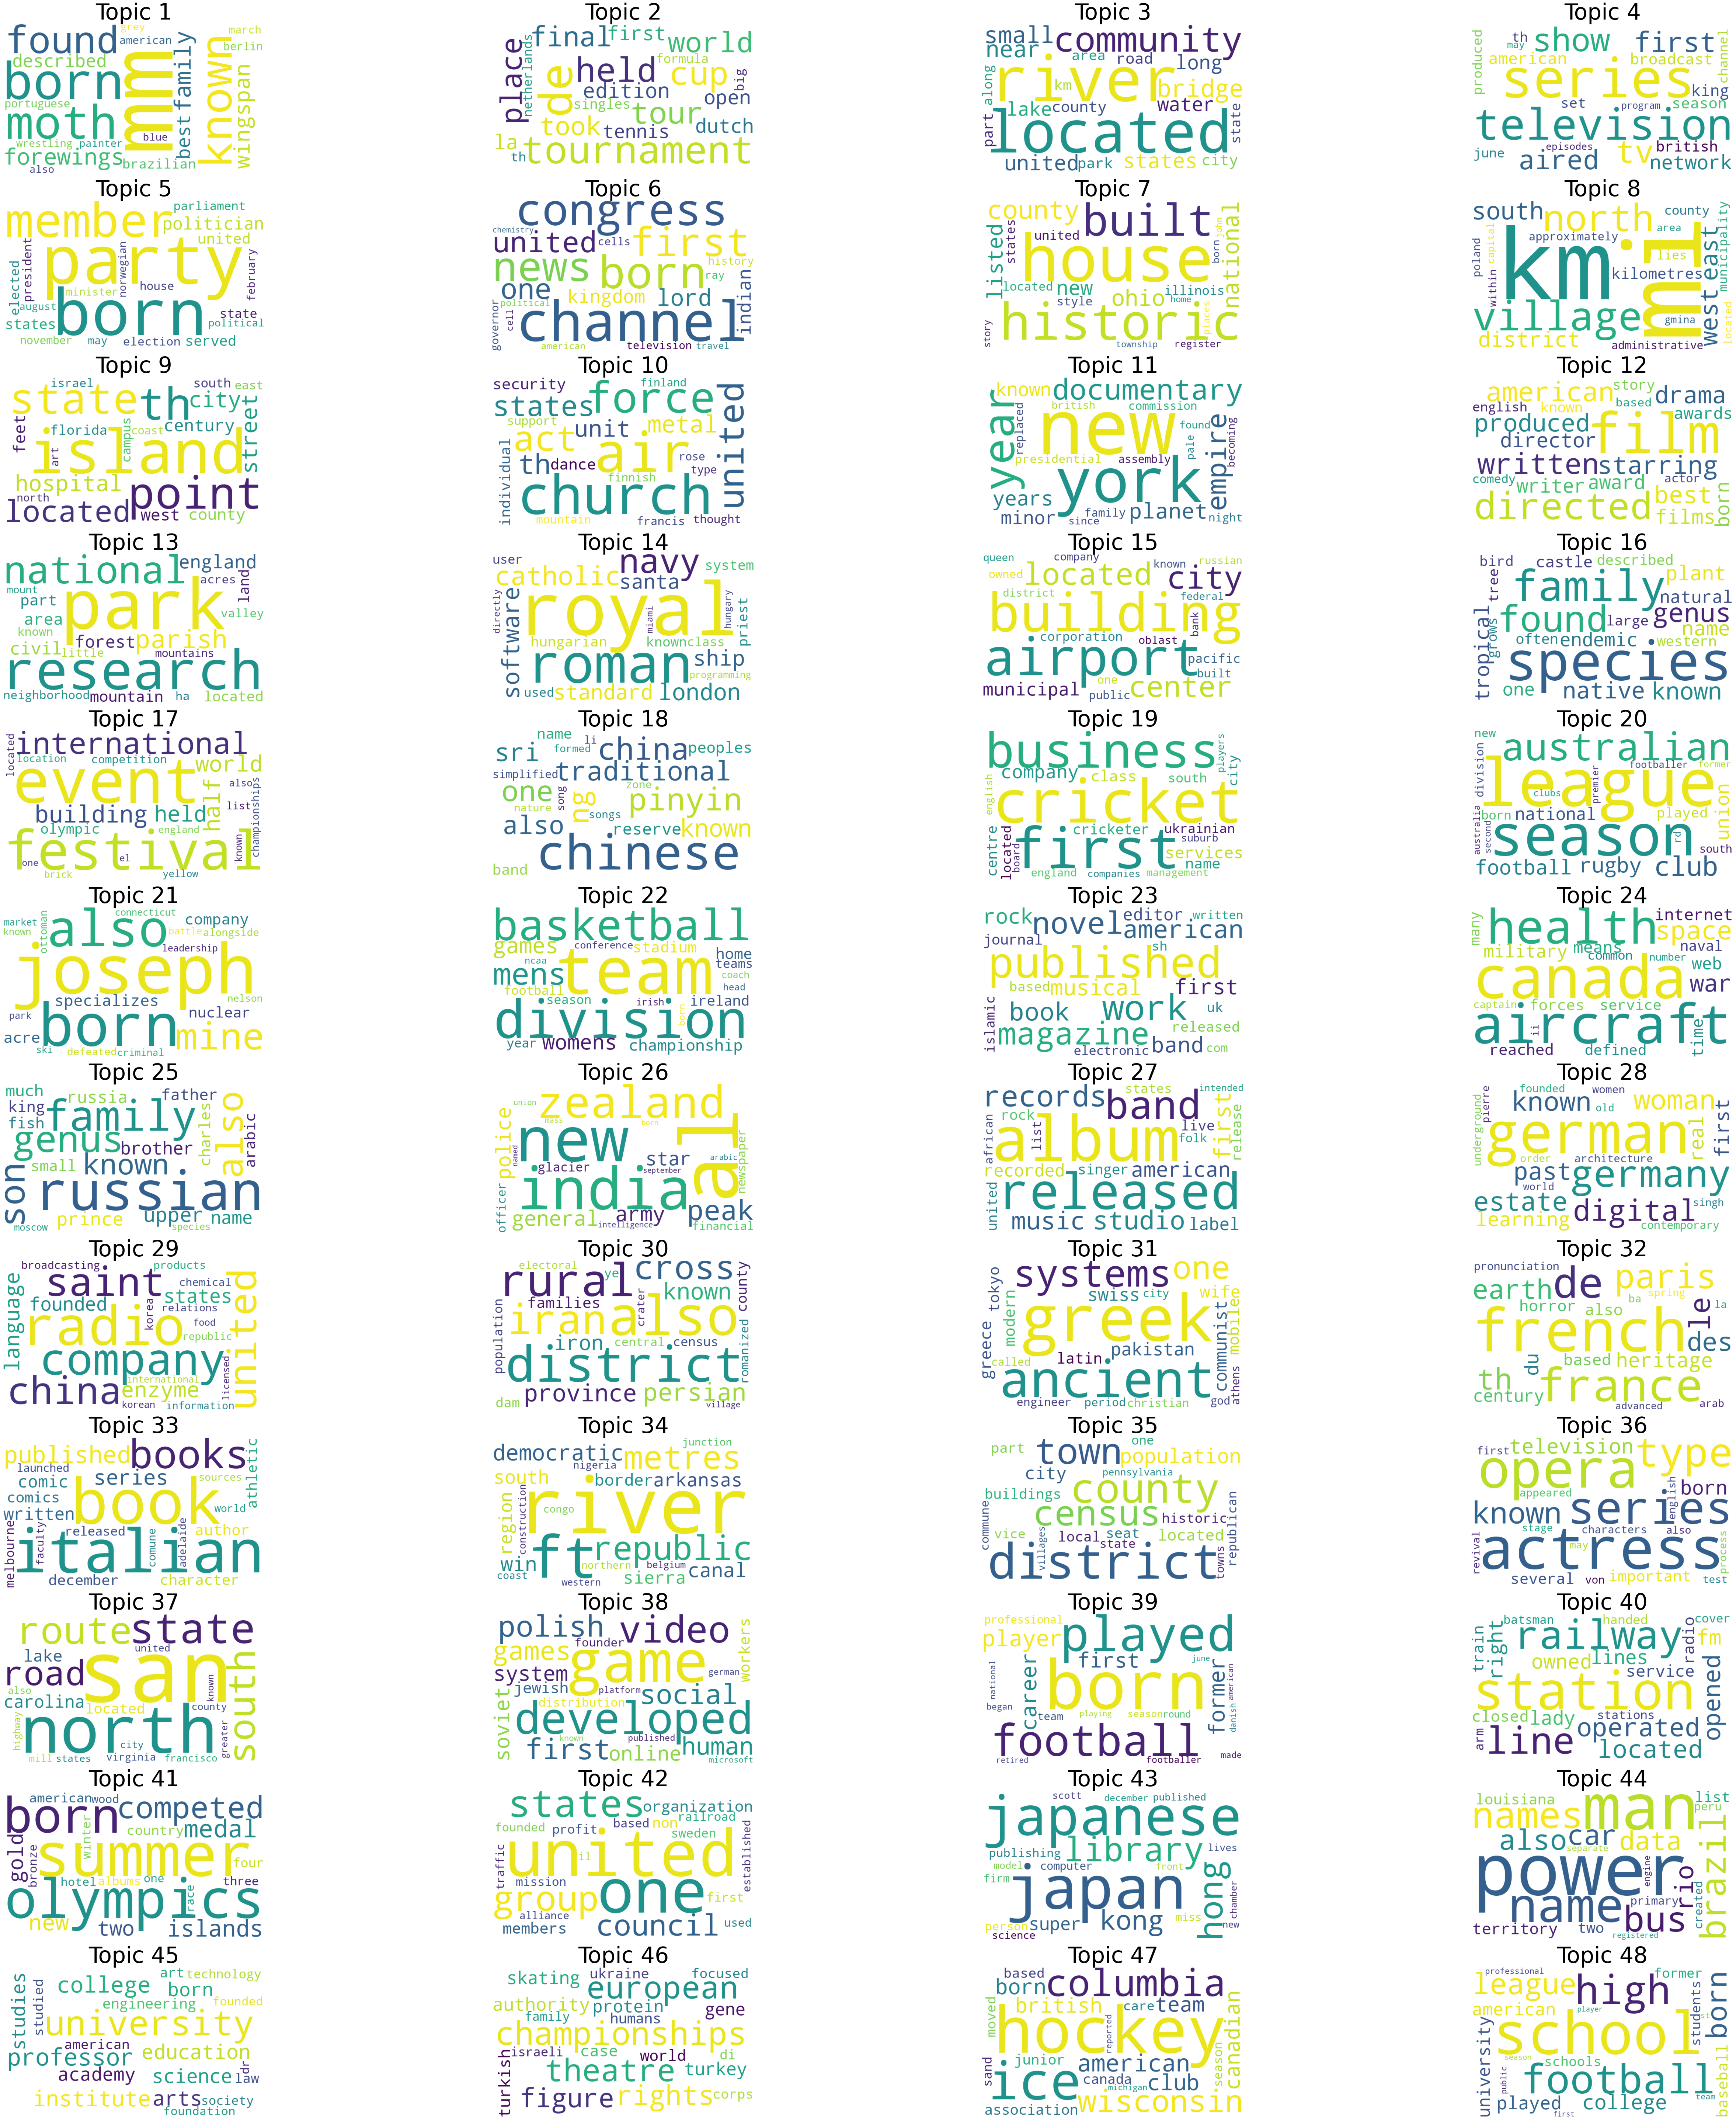

In [77]:
from wordcloud import WordCloud

fig, axs = plt.subplots(ncols=4, nrows=int(lda_model.num_topics/4), figsize=(80,80))
axs = axs.flatten()

for i, t in enumerate(range(lda_model.num_topics)): 
    x = dict(lda_model.show_topic(t, 20))
    im = WordCloud(
        width=800, height=460,
        #max_words = 20,
        background_color='white',
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t+1),fontsize=60)

plt.tight_layout()
plt.show()